# Bike Rentals Project

## Problem definition:
 - Informal: build a model which predict the number of bike rentals;
 - Formal:
     - Taks: predict the number of rented bikes per day;
     - Experience: historical data on bike rentals;
     - Performance: MAE and RMSE;
     
## Assumptions
- The bike rental might depend on time of the day, working day or not, season, and weather;
- Also, it might depend on location, rental fees and number of available bikes, however this data is not presented in the dataset;
- Try to use clustering to reveal some patterns;
- The dependency of target column from every column might be interested;

## Problem solution
- No missing values in the dataset, some columns are normalized;
- Convert dteday column to datetime object;
- Drop columns casual and registered;
- Check relationships between targer value and each column;
- Cluster dataset to find some patterns;
- Check predictions accuracy with linear regression, decision tree and random forest;
- Tune the best model;

In [135]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')

bikes = pd.read_csv('bike_rental_hour.csv')

## Getting familiar with the data

In [136]:
bikes.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [137]:
for col in bikes.columns[2:]:
    print(bikes[col].value_counts().head(10))

3    4496
2    4409
1    4242
4    4232
Name: season, dtype: int64
1    8734
0    8645
Name: yr, dtype: int64
7     1488
5     1488
12    1483
8     1475
3     1473
10    1451
6     1440
11    1437
9     1437
4     1437
Name: mnth, dtype: int64
16    730
17    730
15    729
13    729
14    729
22    728
18    728
19    728
20    728
21    728
Name: hr, dtype: int64
0    16879
1      500
Name: holiday, dtype: int64
6    2512
0    2502
5    2487
1    2479
3    2475
4    2471
2    2453
Name: weekday, dtype: int64
1    11865
0     5514
Name: workingday, dtype: int64
1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64
0.62    726
0.66    693
0.64    692
0.70    690
0.60    675
0.36    671
0.34    645
0.30    641
0.40    614
0.32    611
Name: temp, dtype: int64
0.6212    988
0.5152    618
0.4091    614
0.3333    600
0.6667    593
0.6061    588
0.5303    579
0.5000    575
0.4545    559
0.3030    549
Name: atemp, dtype: int64
0.88    657
0.83    630
0.94    560
0.87    4

Data types presented:
- datetime: dteday;
- nominal: season, yr, mnth, hr, holiday, weekday, workingday;
- ordinal: weathersit;
- discrete: casual, registered, cnt;
- continious: temp, atemp, hum, windspeed;

## Data cleaning

In [138]:
bikes = bikes.drop(['casual', 'registered'], axis=1)
bikes['dteday'] = pd.to_datetime(bikes['dteday'])

## Looking for relationships between columns and target column

### Exploring target column

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64


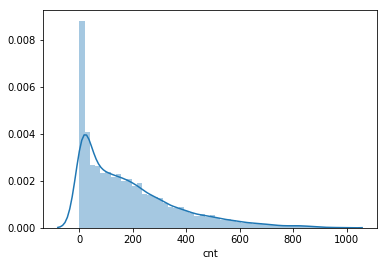

In [139]:
print(bikes['cnt'].describe())
sns.distplot(bikes['cnt'])

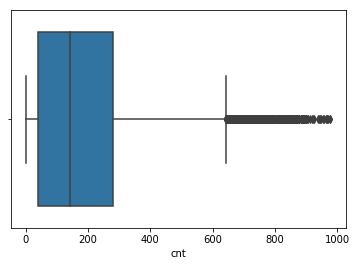

In [140]:
sns.boxplot(bikes['cnt'])

The distribution skewed to the rigth with a lot of outliers. 

### Exploring relationships between target and other columns

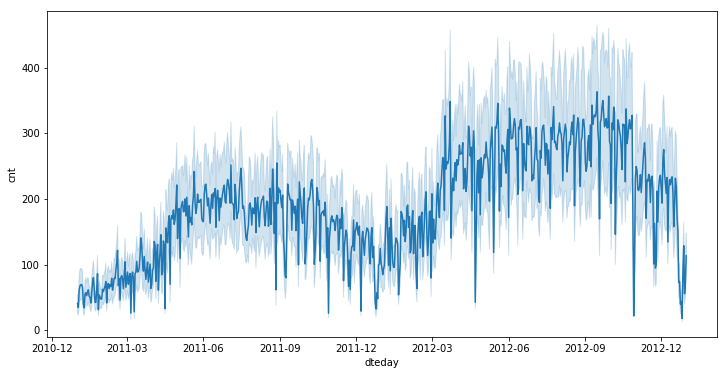

In [141]:
# dteday column
plt.figure(figsize=(12, 6))
sns.lineplot(bikes['dteday'], bikes['cnt'], dashes=False)

There are seasonality and increasing trend. The graph confirm our assumption regarding season impact on number of rentals. 

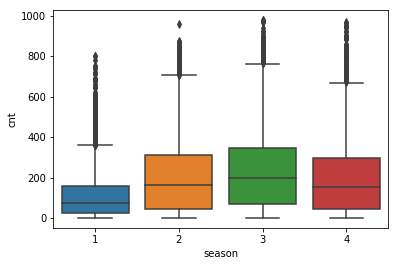

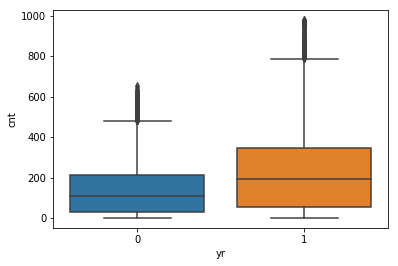

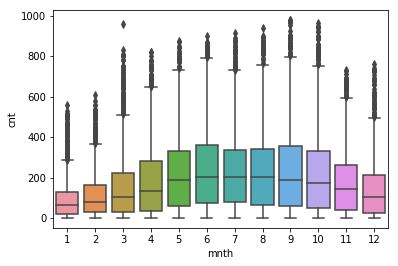

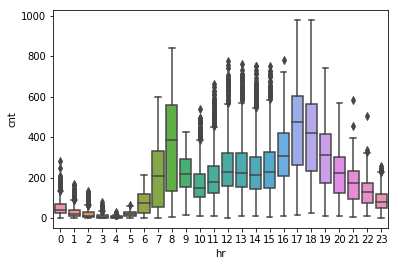

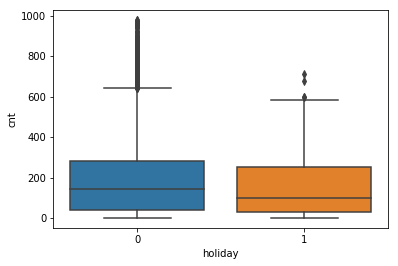

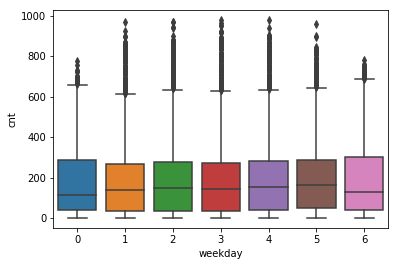

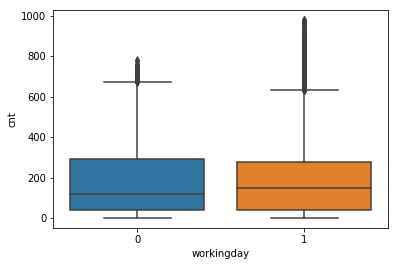

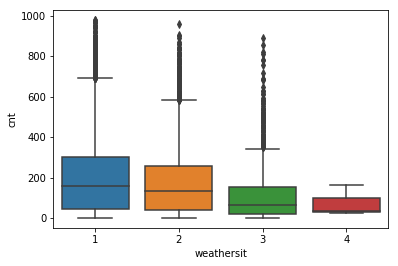

In [142]:
# Nominal and ordinal features features
nom_feats = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
for col in nom_feats:
    sns.boxplot(x=col, y = 'cnt', data=bikes)
    plt.show()

The following features showed some difference between different values of each feature:
- season;
- year;
- mnth;
- hr;
- weathersit;

We will use them for further analysis. Now, let's check correlation with continious features.

               temp     atemp       hum  windspeed       cnt
temp       1.000000  0.987672 -0.069881  -0.023125  0.404772
atemp      0.987672  1.000000 -0.051918  -0.062336  0.400929
hum       -0.069881 -0.051918  1.000000  -0.290105 -0.322911
windspeed -0.023125 -0.062336 -0.290105   1.000000  0.093234
cnt        0.404772  0.400929 -0.322911   0.093234  1.000000


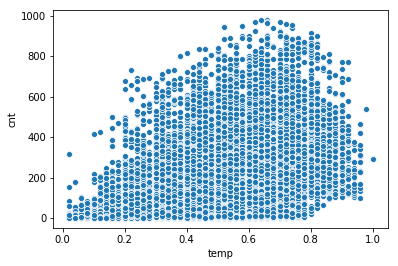

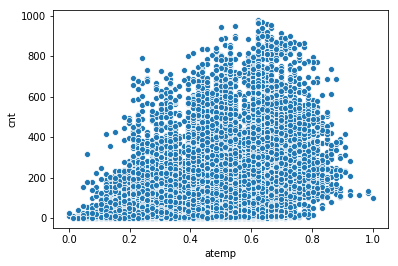

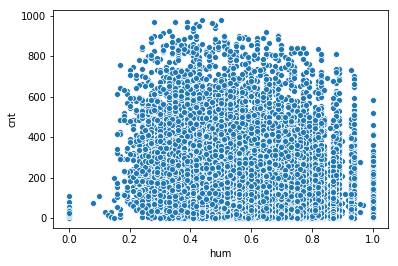

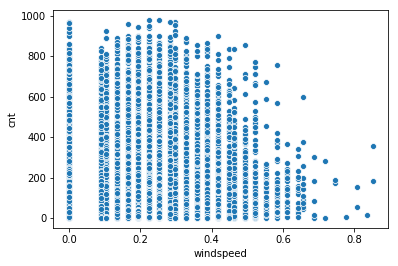

In [143]:
print(bikes[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr())
for col in ['temp', 'atemp', 'hum', 'windspeed']:
    sns.scatterplot(x=col, y='cnt', data=bikes)
    plt.show()

There is no obvious relationships between continious features and target column. At this stage we have some nominal and ordinal data which might be usefull for our analysis. We will use desicion tree and random forest algorithms to make predictions. 

## Algorithm selection

In [144]:
# Define function for algorithm selection
def remove_outliers(data, target):
    return data[np.abs(data[target] - data[target].mean()) < 2 * data[target].std()]

def select_algo(data, target, features=None, auto=True):
    # Instantiate models
    dt_model = DecisionTreeRegressor()
    rf_model = RandomForestRegressor()
    
    # Divide data to train and test data set
    train, test = train_test_split(data.copy(), test_size=0.2)
    
    # Use k-fold validation
    kf = KFold(10, shuffle=True, random_state=1)
    
    if auto:
        start, finish = 3, len(data.columns) - 2
    else:
        start, finish = len(features), len(features) + 1
        print('Custom features')
    
    for i in range(start, finish):
        # Print average MAE and RMSE values
        print('Number of features: {}'.format(i))
        for name, model in [('Decision Tree', dt_model), ('Random Forest', rf_model)]:
            maes = list()
            mses = list()
            for train_index, test_index in kf.split(train):
                # Remove outliers from each fold
                #fold_train = remove_outliers(train.iloc[train_index], target)
                fold_train = train.iloc[train_index]
                fold_test = train.iloc[test_index]
                if auto:
                    # Select features
                    X = fold_train.iloc[:, 2:(len(fold_train.columns) - 1)]
                    Y = fold_train[target]
                    rfe = RFE(rf_model, i)
                    fit = rfe.fit(X, Y)
                    features = list(X.columns[fit.support_])
                    print(features)
                # Fit model and make predictions
                model.fit(fold_train[features], fold_train[target])
                predictions = model.predict(fold_test[features])
                # Append value to corresponding list
                maes.append(mean_absolute_error(fold_test[target], predictions))
                mses.append(mean_squared_error(fold_test[target], predictions))

            print(features)
            print('{} MAE: {}'.format(name, np.mean(maes)))
            print('{} RMSE: {}'.format(name, np.mean(np.sqrt(mses))))
        print()
        
    return train, test
        

features = ['season', 'yr', 'mnth', 'hr', 'weathersit']
#train, test = select_algo(bikes, 'cnt')

In [145]:
train, test = select_algo(bikes, 'cnt', features, auto=False)

Custom features
Number of features: 5
['season', 'yr', 'mnth', 'hr', 'weathersit']
Decision Tree MAE: 63.66116493860467
Decision Tree RMSE: 97.16723583875526
['season', 'yr', 'mnth', 'hr', 'weathersit']
Random Forest MAE: 63.15302931526967
Random Forest RMSE: 96.36484185721847



We can observe that the Random Forest algorithm perform better. We will use this and proposed features for model tuning. The proposed features are 'season', 'yr', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', and 'hum'. 

## Model tuning

In [146]:
def tune_algo(train, features, target):
    # Use k-fold validation
    kf = KFold(10, shuffle=True, random_state=1)
    # Loop over different values of hyperparameter
    for i in range(2, 11, 2):
        # Instantiate the model with this value
        model = RandomForestRegressor(max_depth=20, min_samples_split=i)
        maes = []
        mses = []
        for train_index, test_index in kf.split(train):
                # Remove outliers from each fold
                #fold_train = remove_outliers(train.iloc[train_index], target)
                fold_train = train.iloc[train_index]
                fold_test = train.iloc[test_index]
                # Fit model and make predictions
                model.fit(fold_train[features], fold_train[target])
                predictions = model.predict(fold_test[features])
                # Append value to corresponding list
                maes.append(mean_absolute_error(fold_test[target], predictions))
                mses.append(mean_squared_error(fold_test[target], predictions))

        print('Hyperparameter: {}'.format(i))
        print('MAE: {}'.format(np.mean(maes)))
        print('RMSE: {}'.format(np.mean(np.sqrt(mses))))
        print()
features =  ['season', 'yr', 'mnth', 'hr', 'weekday', 'workingday',
             'weathersit', 'temp', 'atemp', 'hum']
tune_algo(train, features, 'cnt')

Hyperparameter: 2
MAE: 27.27476966858442
RMSE: 45.18360023781749

Hyperparameter: 4
MAE: 27.106342241326058
RMSE: 44.71404481585589

Hyperparameter: 6
MAE: 27.18829770573392
RMSE: 44.99299967825879

Hyperparameter: 8
MAE: 27.154353939705697
RMSE: 44.762923873930966

Hyperparameter: 10
MAE: 27.39339791250969
RMSE: 45.20154157635715



Keep only max_depth parameter at 20.

## Final predictions

In [147]:
def final_predict(train, test, features, target):
    rf = RandomForestRegressor(max_depth=20)
    #train = remove_outliers(train, target)
    rf.fit(train[features], train[target])
    predictions = rf.predict(test[features])
    mae = mean_absolute_error(test[target], predictions)
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    print('MAE {}'.format(mae))
    print('RMSE {}'.format(rmse))
    
final_predict(train, test, features, 'cnt')

MAE 26.781077770009713
RMSE 45.47032715008635


Let's try to improve our result by introducing new features in the dataset.

In [152]:
def day_part(x):
    if x in list(range(7)): y = 1
    elif x in list(range(7, 13)): y = 2
    elif x in list(range(13, 19)): y = 3
    else: y = 4
    return y
test = bikes.copy()
test['day_part'] = test['hr'].apply(day_part)
test = test[['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day_part', 'cnt']]

In [153]:
for col in ['day_part', 'cnt']:
    print(test[col].value_counts())

1    5001
3    4375
2    4363
4    3640
Name: day_part, dtype: int64
5      260
6      236
4      231
3      224
2      208
7      198
8      182
1      158
10     155
11     147
9      128
12     122
13     113
16     105
17     102
14      97
20      91
21      90
26      90
15      89
28      85
23      81
18      79
24      76
31      75
25      72
27      71
19      69
32      68
36      67
      ... 
754      1
977      1
913      1
897      1
865      1
849      1
708      1
804      1
792      1
948      1
728      1
696      1
967      1
863      1
871      1
775      1
727      1
870      1
854      1
806      1
774      1
758      1
630      1
917      1
901      1
725      1
709      1
661      1
629      1
887      1
Name: cnt, Length: 869, dtype: int64


In [155]:
def select_algo(data, target, features=None, auto=True):
    # Instantiate models
    dt_model = DecisionTreeRegressor()
    rf_model = RandomForestRegressor()
    
    # Divide data to train and test data set
    train, test = train_test_split(data.copy(), test_size=0.2)
    
    # Use k-fold validation
    kf = KFold(10, shuffle=True, random_state=1)
    
    if auto:
        start, finish = 3, len(data.columns) - 2
    else:
        start, finish = len(features), len(features) + 1
        print('Custom features')
    
    for i in range(start, finish):
        # Print average MAE and RMSE values
        print('Number of features: {}'.format(i))
        for name, model in [('Decision Tree', dt_model), ('Random Forest', rf_model)]:
            maes = list()
            mses = list()
            for train_index, test_index in kf.split(train):
                # Remove outliers from each fold
                #fold_train = remove_outliers(train.iloc[train_index], target)
                fold_train = train.iloc[train_index]
                fold_test = train.iloc[test_index]
                if auto:
                    # Select features
                    X = fold_train.iloc[:, 2:(len(fold_train.columns) - 1)]
                    Y = fold_train[target]
                    rfe = RFE(rf_model, i)
                    fit = rfe.fit(X, Y)
                    features = list(X.columns[fit.support_])
                # Fit model and make predictions
                model.fit(fold_train[features], fold_train[target])
                predictions = model.predict(fold_test[features])
                # Append value to corresponding list
                maes.append(mean_absolute_error(fold_test[target], predictions))
                mses.append(mean_squared_error(fold_test[target], predictions))

            print(features)
            print('{} MAE: {}'.format(name, np.mean(maes)))
            print('{} RMSE: {}'.format(name, np.mean(np.sqrt(mses))))
        print()
        
    return train, test

train, test = select_algo(test, 'cnt')

Number of features: 3
['hr', 'temp', 'day_part']
Decision Tree MAE: 74.20098146746068
Decision Tree RMSE: 110.74859487052008
['hr', 'temp', 'day_part']
Random Forest MAE: 74.44892112013609
Random Forest RMSE: 111.24687876799268

Number of features: 4
['hr', 'workingday', 'temp', 'day_part']
Decision Tree MAE: 71.07991379923288
Decision Tree RMSE: 109.54137911878952
['yr', 'hr', 'temp', 'day_part']
Random Forest MAE: 66.27351685272342
Random Forest RMSE: 100.72185135202332

Number of features: 5
['yr', 'hr', 'workingday', 'temp', 'day_part']
Decision Tree MAE: 53.170459743439515
Decision Tree RMSE: 86.27771833818606
['yr', 'hr', 'workingday', 'temp', 'day_part']
Random Forest MAE: 47.79849081308903
Random Forest RMSE: 76.93001106593022

Number of features: 6
['yr', 'hr', 'workingday', 'temp', 'hum', 'day_part']
Decision Tree MAE: 47.0540229541744
Decision Tree RMSE: 75.26127940919625
['yr', 'hr', 'workingday', 'temp', 'hum', 'day_part']
Random Forest MAE: 39.48960353098552
Random Forest

In [156]:
features = ['season', 'yr', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit',
            'temp', 'atemp', 'hum', 'day_part']
tune_algo(train, features, 'cnt')

Hyperparameter: 2
MAE: 27.116247619754937
RMSE: 44.89633324448235

Hyperparameter: 4
MAE: 27.021078367322833
RMSE: 44.49415483794149

Hyperparameter: 6
MAE: 26.980565779966355
RMSE: 44.01254046168707

Hyperparameter: 8
MAE: 27.15791948418692
RMSE: 44.53908511271829

Hyperparameter: 10
MAE: 27.334705038507327
RMSE: 44.86106375928968



In [157]:
final_predict(train, test, features, 'cnt')

MAE 27.73272129655367
RMSE 47.68653612728434


In [ ]:
The results is worde, the final model is with initial features. 